<a href="https://colab.research.google.com/github/henningheyen/TransformersExplainability/blob/main/notebooks/Colab_Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Evaluation

In [ ]:
!git clone https://github.com/henningheyen/TransformersExplainability.git

Cloning into 'TransformersExplainability'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 165 (delta 12), reused 17 (delta 8), pack-reused 138
Receiving objects: 100% (165/165), 47.30 MiB | 16.10 MiB/s, done.
Resolving deltas: 100% (92/92), done.
Updating files: 100% (32/32), done.


In [ ]:
%cd TransformersExplainability

/content/TransformersExplainability


In [ ]:
# Installing Dependencies
!pip install lime
!pip install transformers
!pip install sentencepiece
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=0681f62f178a2a8d3104e21c70068dda3c31e2927045e124e8cb9dc12dbcdc9c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset

def make_test_set_cose(size, seed=42): # 1221 max size for mnli

  dataset = load_dataset("cos_e", 'v1.11')['validation']

  random.seed(seed)
  random_indices = random.sample(list(range(len(dataset['question']))), size)

  test_set = dataset[random_indices]
  candidate_labels_list = test_set['choices']

  true_labels = [test_set['choices'][i].index(test_set['answer'][i]) for i in range(size)]

  return {
      'question': test_set['question'],
      'choices': test_set['choices'],
      'answer': test_set['answer'],
      'true_labels': true_labels,
      'extractive_explanation': test_set['extractive_explanation'],
      'candidate_labels_list': candidate_labels_list,
  }



In [ ]:
from datasets import load_dataset

def make_test_set_mnli(size, seed=42): # 9815 max size for mnli

  dataset = load_dataset("multi_nli")['validation_matched']
  new_labels = [2 if label == 1 else 1 if label == 0 else 0 for label in dataset['label']] # original: [entailment:0,neutral:1,contradiction:2] deberta: [contradiction:0,entailment:1,neutral:2]

  # Randomly sample the desired number of indices
  random.seed(seed)
  random_indices = random.sample(list(range(len(dataset['label']))), size)

  test_set = [(dataset['premise'][i], dataset['hypothesis'][i]) for i in random_indices]
  print('check3')
  test_labels = [new_labels[i] for i in random_indices]
  test_labels_text = ['contradiction' if test_labels[i]==0 else 'entailment' if test_labels[i]==1 else 'neutral' for i in range(len(test_labels))]

  return {
      'sentence_pairs': test_set,
      'test_labels': test_labels,
      'test_labels_text': test_labels_text
      }



In [ ]:
# Preprocessing e-SNLI
import pandas as pd
import random

def make_test_set_esnli(size, path='data/esnli_dev.csv', seed=42): # 9842 max size for mnli

    #loading data
    df = pd.read_csv(path)
    df = df[['gold_label', 'Sentence1', 'Sentence2', 'Sentence1_marked_1', 'Sentence2_marked_1', 'Sentence1_Highlighted_1', 'Sentence2_Highlighted_1']]

    dataset = df.to_dict(orient='list')

    random.seed(seed)
    random_indices = random.sample(list(range(df.shape[0])), size)

    sentence_pairs = [(dataset['Sentence1'][i], dataset['Sentence2'][i]) for i in random_indices]
    test_labels_text = [dataset['gold_label'][i] for i in random_indices]
    label_to_num = {'contradiction': 0, 'entailment': 1, 'neutral': 2}
    test_labels = [label_to_num[label] for label in test_labels_text]
    sentence1_marked = [dataset['Sentence1_marked_1'][i] for i in random_indices]
    sentence2_marked = [dataset['Sentence2_marked_1'][i] for i in random_indices]
    sentence1_highlights = [dataset['Sentence1_Highlighted_1'][i] for i in random_indices]
    sentence2_highlights = [dataset['Sentence2_Highlighted_1'][i] for i in random_indices]


    return {
        'sentence_pairs': sentence_pairs,
        'test_labels': test_labels,
        'test_labels_text': test_labels_text,
        'sentence1_marked': sentence1_marked,
        'sentence2_marked': sentence2_marked,
        'sentence1_highlights': sentence1_highlights,
        'sentence2_highlights': sentence2_highlights,
        }


In [ ]:
esnli_size = 9842
mnli_size = 9815
cose_size = 1221

num_batches = 100

In [ ]:
#importing dataset
dataset_esnli = make_test_set_esnli(size=esnli_size) # 9842 is dev size esnli
dataset_mnli = make_test_set_mnli(size=mnli_size) # 9815 is dev size mnli
dataset_cose = make_test_set_cose(size=cose_size) # 1221 is dev size cose

# Quick EDA

In [ ]:
dataset_cose.keys()

dict_keys(['question', 'choices', 'answer', 'true_labels', 'extractive_explanation', 'candidate_labels_list'])

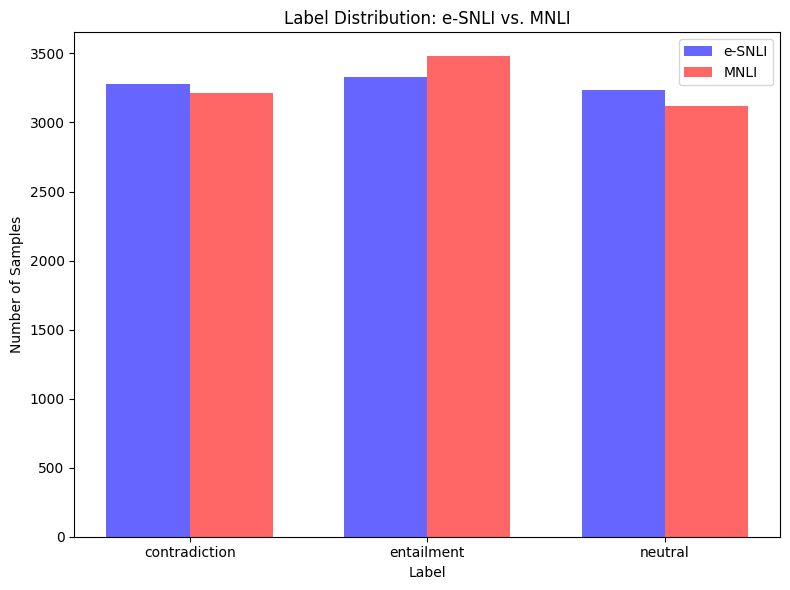

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract label distribution from both datasets:
unique_labels_esnli, counts_esnli = np.unique(dataset_esnli['test_labels_text'], return_counts=True)
unique_labels_mnli, counts_mnli = np.unique(dataset_mnli['test_labels_text'], return_counts=True)

# Check if the unique labels are the same for both datasets:
assert all(unique_labels_esnli == unique_labels_mnli), "The unique labels are different between datasets."

# 2. Plot on the same graph:
bar_width = 0.35
index = np.arange(len(unique_labels_esnli))

plt.figure(figsize=(8, 6))
bar1 = plt.bar(index, counts_esnli, bar_width, color='b', alpha=0.6, label='e-SNLI')
bar2 = plt.bar(index + bar_width, counts_mnli, bar_width, color='r', alpha=0.6, label='MNLI')

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Label Distribution: e-SNLI vs. MNLI')
plt.xticks(index + bar_width / 2, unique_labels_esnli)  # position the labels in the middle of the grouped bars
plt.legend()

plt.tight_layout()
plt.show()


# Natural Langugae Inference

## e-SNLI

In [ ]:
from model import ZeroShotNLI
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
xsmall = ZeroShotNLI(model_name='nli-deberta-v3-xsmall')
small = ZeroShotNLI(model_name='nli-deberta-v3-small')
base = ZeroShotNLI(model_name='nli-deberta-v3-base')
large = ZeroShotNLI(model_name='nli-deberta-v3-large')

models = [
    xsmall,
    small,
    base,
    large
]

model_names = [
    'xsmall',
    'small',
    'base',
    'large'
]

In [ ]:
%%time
deberta_xsmall_pred_esnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = esnli_size/num_batches
  deberta_xsmall_pred_batch = xsmall.get_predictions(dataset_esnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_xsmall_pred_esnli += deberta_xsmall_pred_batch



CPU times: user 8min 24s, sys: 4.65 s, total: 8min 28s
Wall time: 2min 7s


In [ ]:
%%time
deberta_small_pred_esnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = esnli_size/num_batches
  deberta_small_pred_batch = small.get_predictions(dataset_esnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_small_pred_esnli += deberta_small_pred_batch



CPU times: user 12min 1s, sys: 8.04 s, total: 12min 9s
Wall time: 3min 2s


In [ ]:
%%time
deberta_base_pred_esnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = esnli_size/num_batches
  deberta_base_pred_batch = base.get_predictions(dataset_esnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_base_pred_esnli += deberta_base_pred_batch



CPU times: user 24min 41s, sys: 22 s, total: 25min 3s
Wall time: 6min 16s


In [ ]:
%%time
deberta_large_pred_esnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = esnli_size/num_batches
  deberta_large_pred_batch = large.get_predictions(dataset_esnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_large_pred_esnli += deberta_large_pred_batch



CPU times: user 1h 15min 50s, sys: 4min 45s, total: 1h 20min 36s
Wall time: 20min 8s


In [ ]:
predictions_esnli = [
    deberta_xsmall_pred_esnli,
    deberta_small_pred_esnli,
    deberta_base_pred_esnli,
    deberta_large_pred_esnli
    ]

In [ ]:
for i, pred in enumerate(predictions_esnli):
    print(f'{model_names[i]}:', accuracy_score(dataset_esnli['test_labels'], pred))

for pred in predictions_esnli:
    print(pred)

xsmall: 0.9203413940256046
small: 0.9219670798618167
base: 0.9314163787847999
large: 0.9321276163381427
[0, 1, 1, 0, 0, 2, 0, 2, 2, 1, 2, 0, 1, 1, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 1, 2, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 1, 2, 1, 2, 1, 1, 2, 2, 0, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 0, 0, 2, 2, 1, 1, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 2, 1, 1, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0, 1, 2, 0, 2, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 1, 2, 1, 2, 0, 2, 1, 0, 1, 2, 1, 0, 0, 0, 2, 0, 2, 1, 1, 2, 1, 0, 2, 2, 0, 2, 1, 2, 2, 1, 2, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 0, 1, 2, 0, 2, 0, 2, 1, 2, 0, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 1, 1, 1, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 0, 2, 1, 1, 0, 1, 1

e-SNLI full dev set (9842) evaluation (accuracy):
- xsmall: 0.9203413940256046
- small: 0.9219670798618167
- base: 0.9314163787847999
- large: 0.9321276163381427

## MNLI

In [ ]:
%%time
deberta_xsmall_pred_mnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = mnli_size/num_batches
  deberta_xsmall_pred_batch = xsmall.get_predictions(dataset_mnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_xsmall_pred_mnli += deberta_xsmall_pred_batch

print(deberta_xsmall_pred_mnli)



[2, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 0, 2, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 2, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 1, 2, 2, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 1, 1, 0, 2, 2, 2, 1, 0, 2, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 0, 1, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 2, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 1, 0, 2, 0, 2, 1, 2, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 2, 0, 1, 1, 2, 1, 1, 2, 2, 2, 0, 0, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 2, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 2, 1, 0, 

In [ ]:
%%time
deberta_small_pred_mnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = mnli_size/num_batches
  deberta_small_pred_batch = small.get_predictions(dataset_mnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_small_pred_mnli += deberta_small_pred_batch

print(deberta_small_pred_mnli)



[2, 1, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 1, 0, 1, 1, 0, 2, 1, 2, 1, 0, 2, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 1, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 1, 2, 1, 2, 1, 2, 0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 2, 1, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 2, 0, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 2, 1, 2, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 1, 0, 1, 0, 2, 1, 2, 0, 0, 2, 0, 1, 2, 1, 0, 2, 2, 2, 0, 1, 1, 2, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 1, 0, 1, 2, 0, 0, 2, 2, 1, 0, 

In [ ]:
%%time
deberta_base_pred_mnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = mnli_size/num_batches
  deberta_base_pred_batch = base.get_predictions(dataset_mnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_base_pred_mnli += deberta_base_pred_batch

print(deberta_base_pred_mnli)


[2, 1, 0, 0, 2, 0, 2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 0, 2, 0, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 2, 0, 0, 2, 1, 0, 2, 2, 1, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 2, 2, 1, 0, 2, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 0, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 0, 1, 2, 1, 2, 0, 1, 2, 0, 0, 2, 1, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 1, 2, 2, 0, 2, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 1, 1, 2, 0, 2, 0, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 2, 2, 1, 0, 

In [ ]:
%%time
deberta_large_pred_mnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = mnli_size/num_batches
  deberta_large_pred_batch = large.get_predictions(dataset_mnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_large_pred_mnli += deberta_large_pred_batch

print(deberta_large_pred_mnli)

test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
CPU times: user 2h 40min, sys: 54min 26s, total: 3h 34min 26s
Wall time: 54min 31s


In [ ]:
predictions_mnli = [
    deberta_xsmall_pred_mnli,
    deberta_small_pred_mnli,
    deberta_base_pred_mnli,
    deberta_large_pred_mnli
    ]

In [ ]:
for i, pred in enumerate(predictions_mnli):
    print(f'{model_names[i]}:', accuracy_score(dataset_mnli['test_labels'], pred))

for pred in predictions_mnli:
    print(pred)

xsmall: 0.878349465104432
small: 0.8779419256240448
base: 0.8999490575649516
large: 0.9019867549668874
(0, [2, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 0, 2, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 2, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 1, 2, 2, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 1, 1, 0, 2, 2, 2, 1, 0, 2, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 0, 1, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 2, 1, 2, 1, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 1, 0, 2, 0, 2, 1, 2, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 2, 0, 1, 1, 2, 1, 1, 2, 2, 2, 0, 0

MNLI full dev set (9815) evaluation (accuracy):
- xsmall: 0.878349465104432
- small: 0.8779419256240448
- base: 0.8999490575649516
- large: 0.9019867549668874

# Zero Shot Classification

In [ ]:
from model import ZeroShotLearner


In [ ]:
xsmall = ZeroShotLearner('cross-encoder/nli-deberta-v3-xsmall')
small = ZeroShotLearner('cross-encoder/nli-deberta-v3-small')
base = ZeroShotLearner('cross-encoder/nli-deberta-v3-base')
large = ZeroShotLearner('cross-encoder/nli-deberta-v3-large')

models = [
     xsmall,
     small,
     base,
     large,
 ]

model_names = [
     'xsmall',
     'small',
     'base',
     'large',
 ]

In [ ]:
%%time
deberta_xsmall_results_cose = xsmall.get_results(dataset_cose['question'], candidate_labels_list=dataset_cose['candidate_labels_list'])

CPU times: user 20min 12s, sys: 2.8 s, total: 20min 15s
Wall time: 5min 3s


In [ ]:
%%time
deberta_small_results_cose = small.get_results(dataset_cose['question'], candidate_labels_list=dataset_cose['candidate_labels_list'])

CPU times: user 26min 34s, sys: 2.27 s, total: 26min 36s
Wall time: 6min 38s


In [ ]:
%%time
deberta_base_results_cose = base.get_results(dataset_cose['question'], candidate_labels_list=dataset_cose['candidate_labels_list'])

CPU times: user 52min 23s, sys: 4.41 s, total: 52min 28s
Wall time: 13min 6s


In [ ]:
%%time
deberta_large_results_cose = large.get_results(dataset_cose['question'], candidate_labels_list=dataset_cose['candidate_labels_list'])

CPU times: user 2h 52min 40s, sys: 36.9 s, total: 2h 53min 17s
Wall time: 43min 15s


In [ ]:
results_cose = [
    deberta_xsmall_results_cose,
    deberta_small_results_cose,
    deberta_base_results_cose,
    deberta_large_results_cose
    ]

In [ ]:
predictions_cose = [model.get_predictions(result, dataset_cose['candidate_labels_list']) for (model, result) in zip(models,results_cose)]

for pred in predictions_cose:
  print(pred)

[1, 4, 1, 4, 2, 4, 3, 4, 2, 3, 0, 4, 0, 1, 1, 0, 3, 4, 4, 3, 2, 0, 1, 4, 0, 0, 1, 3, 3, 4, 4, 2, 3, 1, 1, 4, 2, 0, 0, 1, 0, 3, 4, 1, 3, 0, 3, 3, 3, 1, 4, 4, 0, 3, 0, 0, 4, 2, 3, 1, 4, 1, 0, 4, 4, 2, 2, 1, 0, 4, 0, 3, 0, 3, 4, 3, 1, 0, 4, 3, 2, 1, 4, 0, 3, 1, 4, 2, 0, 2, 2, 2, 4, 2, 2, 1, 0, 3, 4, 3, 0, 2, 3, 0, 0, 0, 4, 4, 0, 2, 1, 1, 0, 3, 1, 3, 3, 3, 3, 0, 4, 1, 4, 1, 4, 4, 0, 4, 4, 3, 3, 1, 4, 4, 0, 3, 3, 1, 0, 0, 3, 0, 0, 1, 3, 2, 1, 3, 3, 2, 2, 4, 1, 0, 3, 1, 0, 2, 4, 0, 4, 4, 0, 0, 4, 2, 4, 2, 1, 0, 0, 2, 2, 2, 0, 4, 0, 2, 1, 3, 0, 3, 0, 4, 1, 3, 4, 3, 1, 2, 1, 2, 3, 0, 0, 2, 4, 3, 2, 4, 1, 3, 4, 0, 3, 1, 4, 1, 0, 1, 3, 1, 0, 4, 3, 1, 4, 2, 0, 1, 2, 2, 3, 4, 3, 3, 4, 1, 3, 3, 1, 0, 0, 1, 3, 3, 1, 4, 2, 4, 2, 3, 3, 0, 0, 0, 2, 4, 0, 1, 3, 4, 0, 2, 3, 3, 0, 3, 3, 4, 4, 1, 2, 4, 3, 3, 2, 2, 3, 1, 0, 0, 4, 2, 2, 4, 2, 0, 2, 3, 3, 0, 1, 0, 2, 4, 2, 2, 2, 4, 0, 2, 1, 3, 2, 1, 1, 0, 4, 2, 4, 0, 3, 0, 0, 0, 3, 4, 2, 2, 0, 0, 3, 4, 2, 4, 2, 0, 1, 1, 3, 0, 2, 1, 2, 2, 1, 0, 3, 4, 3, 2, 1, 

In [ ]:
for i, prediction in enumerate(predictions_cose):
    print(f'accuracy ({model_names[i]}): ', accuracy_score(prediction, dataset_cose['true_labels']))

for pred in predictions_cose:
    print(pred)

accuracy (xsmall):  0.3308763308763309
accuracy (small):  0.3357903357903358
accuracy (base):  0.35872235872235875
accuracy (large):  0.3775593775593776
[1, 4, 1, 4, 2, 4, 3, 4, 2, 3, 0, 4, 0, 1, 1, 0, 3, 4, 4, 3, 2, 0, 1, 4, 0, 0, 1, 3, 3, 4, 4, 2, 3, 1, 1, 4, 2, 0, 0, 1, 0, 3, 4, 1, 3, 0, 3, 3, 3, 1, 4, 4, 0, 3, 0, 0, 4, 2, 3, 1, 4, 1, 0, 4, 4, 2, 2, 1, 0, 4, 0, 3, 0, 3, 4, 3, 1, 0, 4, 3, 2, 1, 4, 0, 3, 1, 4, 2, 0, 2, 2, 2, 4, 2, 2, 1, 0, 3, 4, 3, 0, 2, 3, 0, 0, 0, 4, 4, 0, 2, 1, 1, 0, 3, 1, 3, 3, 3, 3, 0, 4, 1, 4, 1, 4, 4, 0, 4, 4, 3, 3, 1, 4, 4, 0, 3, 3, 1, 0, 0, 3, 0, 0, 1, 3, 2, 1, 3, 3, 2, 2, 4, 1, 0, 3, 1, 0, 2, 4, 0, 4, 4, 0, 0, 4, 2, 4, 2, 1, 0, 0, 2, 2, 2, 0, 4, 0, 2, 1, 3, 0, 3, 0, 4, 1, 3, 4, 3, 1, 2, 1, 2, 3, 0, 0, 2, 4, 3, 2, 4, 1, 3, 4, 0, 3, 1, 4, 1, 0, 1, 3, 1, 0, 4, 3, 1, 4, 2, 0, 1, 2, 2, 3, 4, 3, 3, 4, 1, 3, 3, 1, 0, 0, 1, 3, 3, 1, 4, 2, 4, 2, 3, 3, 0, 0, 0, 2, 4, 0, 1, 3, 4, 0, 2, 3, 3, 0, 3, 3, 4, 4, 1, 2, 4, 3, 3, 2, 2, 3, 1, 0, 0, 4, 2, 2, 4, 2, 0, 2, 3, 3, 0, 

CoS-e full dev set (1221) evaluation (accuracy):
- xsmall: 0.3308763308763309
- small: 0.3357903357903358
- base: 0.35872235872235875
- large: 0.3775593775593776


##Logging the results

In [ ]:
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

results = {
    'esnli': {
        'true': dataset_esnli['test_labels'],
          'xsmall': {
              'pred': predictions_esnli[0],
              'accuracy': accuracy_score(dataset_esnli['test_labels'], predictions_esnli[0]),
              'percision': precision_score(dataset_esnli['test_labels'], predictions_esnli[0], average='macro'),
              'recall': recall_score(dataset_esnli['test_labels'], predictions_esnli[0], average='macro'),
              'f1': f1_score(dataset_esnli['test_labels'], predictions_esnli[0], average='macro'),
          },
          'small': {
              'pred': predictions_esnli[1],
              'accuracy': accuracy_score(dataset_esnli['test_labels'], predictions_esnli[1]),
              'percision': precision_score(dataset_esnli['test_labels'], predictions_esnli[1], average='macro'),
              'recall': recall_score(dataset_esnli['test_labels'], predictions_esnli[1], average='macro'),
              'f1': f1_score(dataset_esnli['test_labels'], predictions_esnli[1], average='macro'),
          },
          'base': {
              'pred': predictions_esnli[2],
              'accuracy': accuracy_score(dataset_esnli['test_labels'], predictions_esnli[2]),
              'percision': precision_score(dataset_esnli['test_labels'], predictions_esnli[2], average='macro'),
              'recall': recall_score(dataset_esnli['test_labels'], predictions_esnli[2], average='macro'),
              'f1': f1_score(dataset_esnli['test_labels'], predictions_esnli[2], average='macro'),
          },
          'large': {
              'pred': predictions_esnli[3],
              'accuracy': accuracy_score(dataset_esnli['test_labels'], predictions_esnli[3]),
              'percision': precision_score(dataset_esnli['test_labels'], predictions_esnli[3], average='macro'),
              'recall': recall_score(dataset_esnli['test_labels'], predictions_esnli[3], average='macro'),
              'f1': f1_score(dataset_esnli['test_labels'], predictions_esnli[3], average='macro'),
          },
    },
        'mnli': {
          'true': dataset_mnli['test_labels'],
          'xsmall': {
              'pred': predictions_mnli[0],
              'accuracy': accuracy_score(dataset_mnli['test_labels'], predictions_mnli[0]),
              'percision': precision_score(dataset_mnli['test_labels'], predictions_mnli[0], average='macro'),
              'recall': recall_score(dataset_mnli['test_labels'], predictions_mnli[0], average='macro'),
              'f1': f1_score(dataset_mnli['test_labels'], predictions_mnli[0], average='macro'),
          },
          'small': {
              'pred': predictions_mnli[1],
              'accuracy': accuracy_score(dataset_mnli['test_labels'], predictions_mnli[1]),
              'percision': precision_score(dataset_mnli['test_labels'], predictions_mnli[1], average='macro'),
              'recall': recall_score(dataset_mnli['test_labels'], predictions_mnli[1], average='macro'),
              'f1': f1_score(dataset_mnli['test_labels'], predictions_mnli[1], average='macro'),
          },
          'base': {
              'pred': predictions_mnli[2],
              'accuracy': accuracy_score(dataset_mnli['test_labels'], predictions_mnli[2]),
              'percision': precision_score(dataset_mnli['test_labels'], predictions_mnli[2], average='macro'),
              'recall': recall_score(dataset_mnli['test_labels'], predictions_mnli[2], average='macro'),
              'f1': f1_score(dataset_mnli['test_labels'], predictions_mnli[2], average='macro'),
          },
          'large': {
              'pred': predictions_mnli[3],
              'accuracy': accuracy_score(dataset_mnli['test_labels'], predictions_mnli[3]),
              'percision': precision_score(dataset_mnli['test_labels'], predictions_mnli[3], average='macro'),
              'recall': recall_score(dataset_mnli['test_labels'], predictions_mnli[3], average='macro'),
              'f1': f1_score(dataset_mnli['test_labels'], predictions_mnli[3], average='macro'),
          },
    },
        'cose': {
          'true': dataset_cose['true_labels'],
          'xsmall': {
              'pred': predictions_cose[0],
              'accuracy': accuracy_score(dataset_cose['true_labels'], predictions_cose[0]),
          },
          'small': {
              'pred': predictions_cose[1],
              'accuracy': accuracy_score(dataset_cose['true_labels'], predictions_cose[1]),
          },
          'base': {
              'pred': predictions_cose[2],
              'accuracy': accuracy_score(dataset_cose['true_labels'], predictions_cose[2]),
          },
          'large': {
              'pred': predictions_cose[3],
              'accuracy': accuracy_score(dataset_cose['true_labels'], predictions_cose[3]),
          },
    },
}

# results are of type np.int64 which is not serializable so we convert it to int()
def convert_numpy_int(item):
    if isinstance(item, np.int64):
        return int(item)
    elif isinstance(item, list):
        return [convert_numpy_int(sub_item) for sub_item in item]
    elif isinstance(item, dict):
        return {key: convert_numpy_int(value) for key, value in item.items()}
    else:
        return item

results_converted = convert_numpy_int(results)

# Specify the file name
output_file = 'results.json'

# Save the dictionary as a JSON file
with open(output_file, 'w') as json_file:
    json.dump(results_converted, json_file, indent=4)

# Visualisations

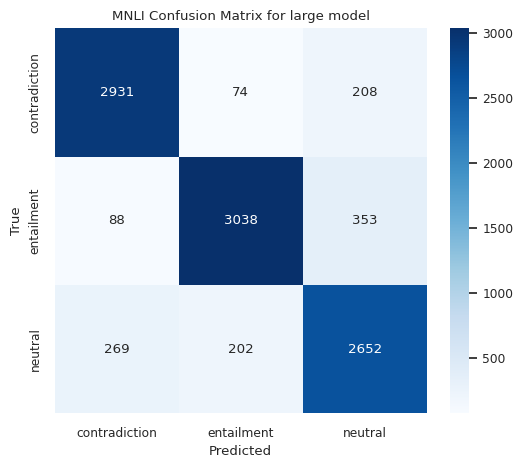

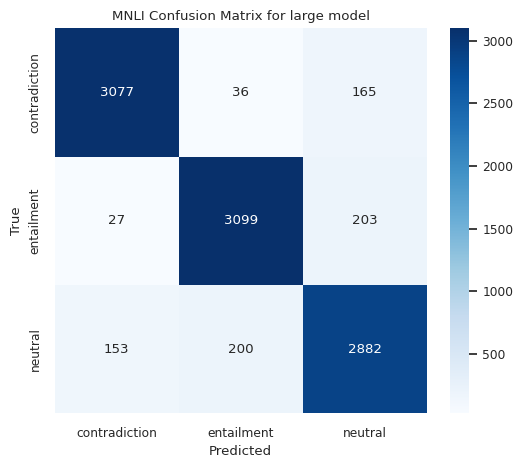

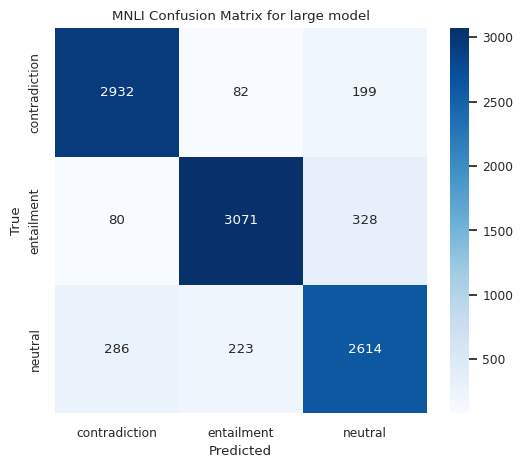

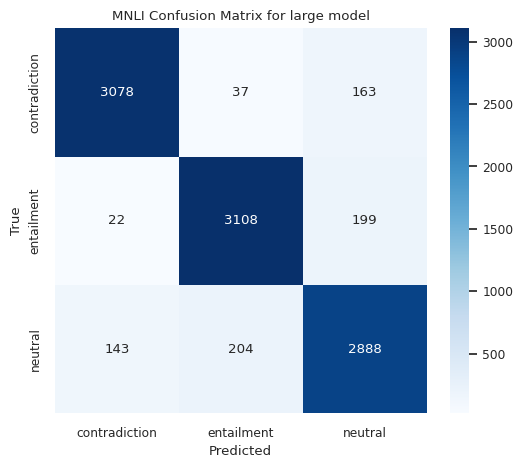

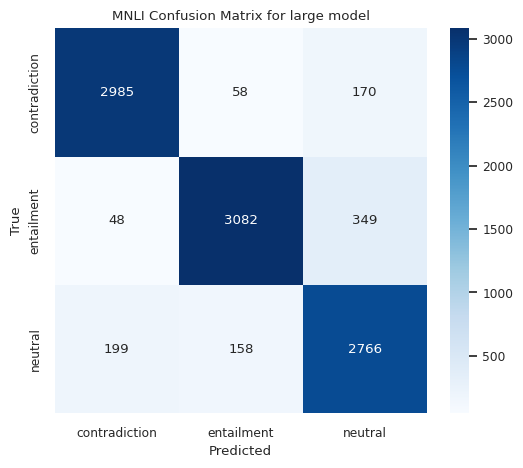

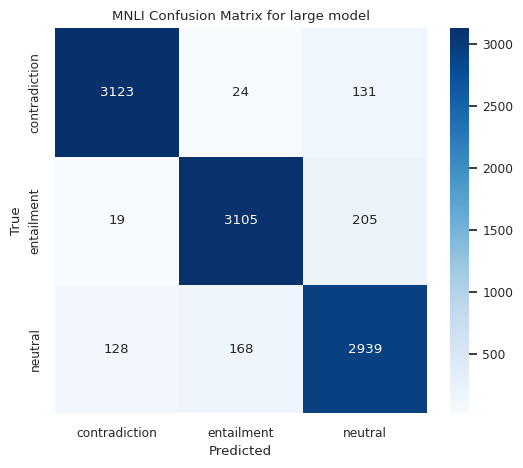

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Labels for the classes
class_names = ['contradiction', 'entailment', 'neutral']

# Calculate the confusion matrix

for i in range(3):

  for dataset, prediction in zip([dataset_mnli, dataset_esnli],[predictions_mnli, predictions_esnli]):

    y_pred = prediction[i]
    y_true = dataset['test_labels']

    conf_matrix = confusion_matrix(y_true, y_pred)

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.set(font_scale=0.8)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('MNLI Confusion Matrix for large model')
    plt.show()




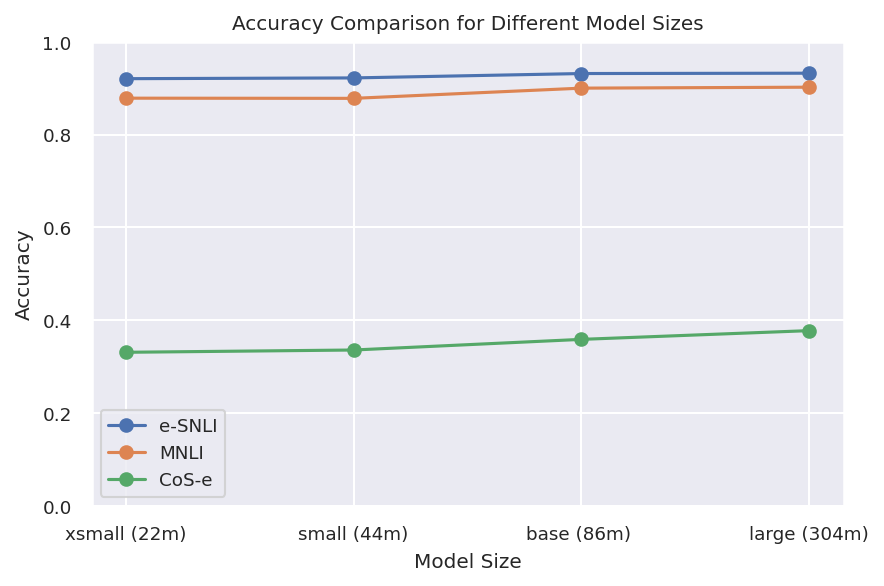

In [ ]:
import matplotlib.pyplot as plt

# Extract the data for plotting
model_sizes = ['xsmall (22m)', 'small (44m)', 'base (86m) ', 'large (304m)']
datasets = ['esnli', 'mnli', 'cose']
dataset_labels = ['e-SNLI', 'MNLI', 'CoS-e']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# Iterate through each dataset
for i,dataset in enumerate(datasets):
    dataset_results = results[dataset]
    accuracies = [dataset_results[model]['accuracy'] for model in model_names]
    ax.plot(model_sizes, accuracies, marker='o', label=dataset_labels[i])

ax.set_title("Accuracy Comparison for Different Model Sizes")
ax.set_xlabel("Model Size")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1)  # Set y-axis limits to 0 to 1
ax.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


StopIteration: ignored

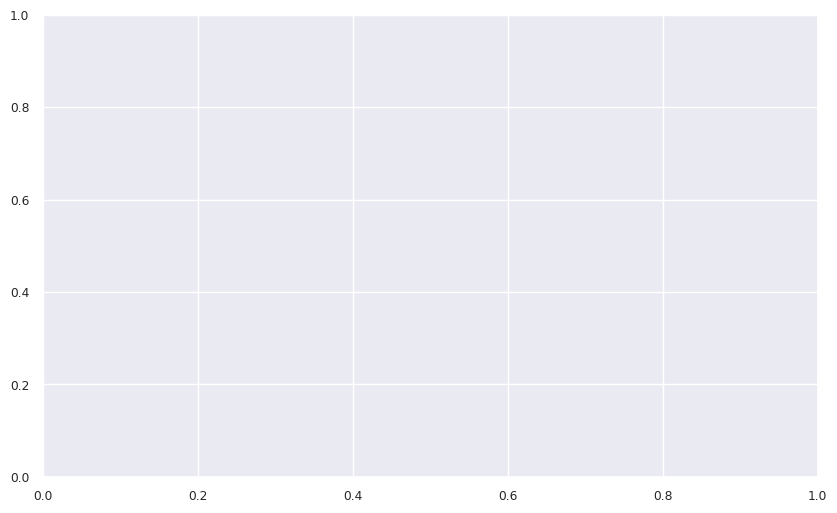

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem, t

# Extract the data for plotting
model_sizes = ['xsmall', 'small', 'base', 'large']
datasets = ['esnli', 'mnli', 'cose']

# Set the desired confidence level
confidence_level = 0.95

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each dataset
for dataset in datasets:
    dataset_results = results[dataset]
    accuracies = [dataset_results[model]['accuracy'] for model in model_sizes]

    # Calculate the standard error of the mean (SEM)
    sem_values = [sem(dataset_results[model]['accuracy']) for model in model_sizes]

    # Calculate the confidence interval
    n = len(accuracies)
    dof = n - 1  # Degrees of freedom
    alpha = 1 - confidence_level
    t_value = t.ppf(1 - alpha / 2, dof)  # T-score for given confidence level and degrees of freedom

    confidence_intervals = [t_value * sem_value for sem_value in sem_values]

    ax.errorbar(model_sizes, accuracies, yerr=confidence_intervals, marker='o', label=dataset)

ax.set_title("Accuracy Comparison for Different Model Sizes")
ax.set_xlabel("Model Size")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()
